# Get warp images from the PS1 image server
Query the PS1 image server to get a list of single-epoch <a href="https://outerspace.stsci.edu/x/KYOc">warp images</a> and retrieve some images.  This sample script demonstrates the use of the PS1 image services.  See the <a href="https://outerspace.stsci.edu/x/ioOc">PS1 Image Cutout Service documentation</a> for details of the services being used.  This notebook is available for 
<a href="https://ps1images.stsci.edu/ps1warps.ipynb" download="">download</a>.

In [1]:
from __future__ import print_function
%matplotlib inline
import numpy
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO
import pylab

## Helper functions to query the list of images and to extract images

In [2]:
def getimagelist(ra,dec,size=240,filters="grizy",imagetype="stack"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    iamgetype = image type(s) to return. May be a comma-separated string or a list of strings.
    Returns a table with the results
    """
    
    # list of available image types
    types = ("stack,stack.wt,stack.mask,stack.exp,stack.num,stack.expwt,stack.psf,stack.mdc,stack.cmf,"
             "warp,warp.wt,warp.mask,warp.cmf,warp.mdc").split(',')
    dtype = {}
    for t in types:
        dtype[t] = 1
    try:
        itypes = imagetype.split(',')
    except AttributeError:
        pass
    itypes = [x.strip().lower() for x in itypes]
    for t in itypes:
        if t not in dtype:
            raise ValueError("Illegal imagetype '{}'".format(t))
    stypes = ",".join(itypes)
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}&type={stypes}").format(**locals())
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False,
          imagetype="stack"):
    
    """Get URLs for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel).  If size=None and
           format="fits", this returns the URL to download the entire skycell.
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    imagetype = type or list of legal image types
    Returns a list of strings with the URLs or a single string if color is True.
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    if size is None:
        if format != "fits":
            raise ValueError("Format must be fits for size=None")
    table = getimagelist(ra,dec,size=size,filters=filters,imagetype=imagetype)
    if size is None:
        # download full FITS images
        url = ["https://ps1images.stsci.edu"+x for x in table['filename']]
        return url
    # cutout images using fitscut.cgi
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[numpy.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im


def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    
    """Get grayscale image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

## Sample JPEG images
This gets single-band grayscale and color JPEG images at the position of the Crab Nebula.  The extracted region size is 1280 pixels = 320 arcsec.

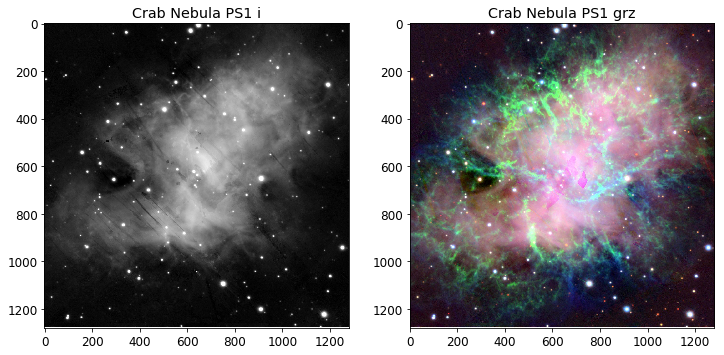

In [3]:
# Crab Nebula position
ra = 83.633210
dec = 22.014460
size = 1280

# grayscale image
gim = getgrayim(ra,dec,size=size,filter="i")
# color image
cim = getcolorim(ra,dec,size=size,filters="grz")

pylab.rcParams.update({'font.size':12})
pylab.figure(1,(12,6))
pylab.subplot(121)
pylab.imshow(gim,origin="upper")
pylab.title('Crab Nebula PS1 i')
pylab.subplot(122)
pylab.title('Crab Nebula PS1 grz')
pylab.imshow(cim,origin="upper")

## Load and display a FITS image

Note that the $y$-axis is flipped in the JPEG image compared with the original FITS image.

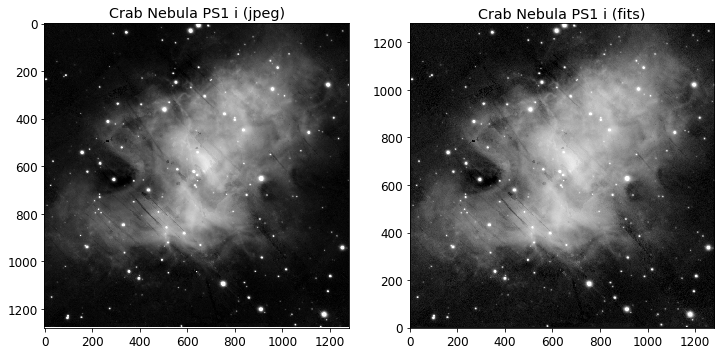

In [4]:
from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch

fitsurl = geturl(ra, dec, size=size, filters="i", format="fits")
fh = fits.open(fitsurl[0])
fim = fh[0].data
# replace NaN values with zero for display
fim[numpy.isnan(fim)] = 0.0
# set contrast to something reasonable
transform = AsinhStretch() + PercentileInterval(99.5)
bfim = transform(fim)

pylab.figure(1,(12,6))
pylab.subplot(121)
pylab.imshow(gim,origin="upper")
pylab.title('Crab Nebula PS1 i (jpeg)')

pylab.subplot(122)
pylab.title('Crab Nebula PS1 i (fits)')
pylab.imshow(bfim,cmap="gray",origin="lower")

## Download a grid of warp images for the Coma cluster

Note this may take quite a bit of memory and time.  size=None returns the full skycell images (about 6200x6200 pixels).  Use a smaller size to speed it up.

In [24]:
ra = 194.898346
dec = 27.958886
# for 1024x1024 pixel cutouts
size = 1024
size = 512
# for full skycells
# size = None

# get URLs for warp images
warpurls = geturl(ra, dec, size=size, filters="r", format="fits", imagetype="warp")
# get URLs for warp.mask images
maskurls = geturl(ra, dec, size=size, filters="r", format="fits", imagetype="warp.mask")
if len(maskurls) != len(warpurls):
    raise Exception("Uh-oh, mismatch in number of warp/mask images")

for i, url in enumerate(warpurls):
    fh = fits.open(url)
    if len(fh)>1:
        fim = fh[1].data
    else:
        fim = fh[0].data
    # replace NaN values with zero
    fim[numpy.isnan(fim)] = 0.0
    # assume all images will be the same size
    if i == 0:
        wstack = numpy.empty((len(warpurls),fim.shape[0],fim.shape[1]),dtype=fim.dtype)
    wstack[i,:,:] = fim
    fh.close()
    print("Read warp image {} of {}".format(i+1, len(warpurls)))

for i, url in enumerate(maskurls):
    fh = fits.open(url)
    if len(fh)>1:
        fim = fh[1].data
    else:
        fim = fh[0].data
    fim[numpy.isnan(fim)] = 0.0
    if i == 0:
        wmask = numpy.empty((len(maskurls),fim.shape[0],fim.shape[1]),dtype=fim.dtype)
    wmask[i,:,:] = fim
    fh.close()
    print("Read warp.mask image {} of {}".format(i+1, len(maskurls)))

# eliminate warp images that are completely blank
nnonblank = (wstack!=0).reshape(wstack.shape[0],-1).sum(axis=1)
w = numpy.where(nnonblank != 0)[0]
if len(w) != wstack.shape[0]:
    print("{} of {} warps are blank".format(wstack.shape[0]-len(w),wstack.shape[0]))
    wstack = wstack[w]
    wmask = wmask[w]

# get the PS1 stack image
stackurl = geturl(ra, dec, size=size, filters="r", format="fits", imagetype="stack")
fh = fits.open(stackurl[0])
if len(fh) > 1:
    stackim = fh[1].data
else:
    stackim = fh[0].data
stackim[numpy.isnan(stackim)] = 0.0
fh.close()
print("Read stack image")

Read warp image 1 of 14
Read warp image 2 of 14
Read warp image 3 of 14
Read warp image 4 of 14
Read warp image 5 of 14
Read warp image 6 of 14
Read warp image 7 of 14
Read warp image 8 of 14
Read warp image 9 of 14
Read warp image 10 of 14
Read warp image 11 of 14
Read warp image 12 of 14
Read warp image 13 of 14
Read warp image 14 of 14
Read warp.mask image 1 of 14
Read warp.mask image 2 of 14
Read warp.mask image 3 of 14
Read warp.mask image 4 of 14
Read warp.mask image 5 of 14
Read warp.mask image 6 of 14
Read warp.mask image 7 of 14
Read warp.mask image 8 of 14
Read warp.mask image 9 of 14
Read warp.mask image 10 of 14
Read warp.mask image 11 of 14
Read warp.mask image 12 of 14
Read warp.mask image 13 of 14
Read warp.mask image 14 of 14
2 of 14 warps are blank
Read stack image


### Construct another version of stacked images by summing warp images

This may be worse than the PS1 pipeline stack, or in some cases it may be better (at least cosmetically).

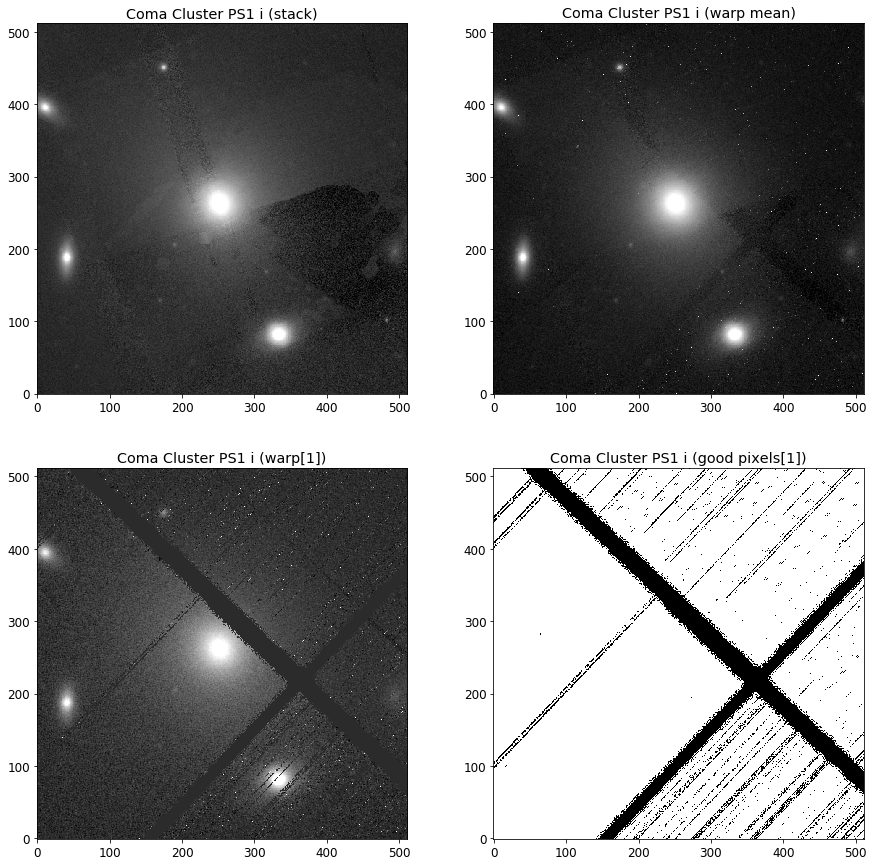

In [25]:
# get mean of warp images ignoring empty pixels
meanim1 = wstack.sum(axis=0)/(wstack!=0).sum(axis=0).clip(min=1)
thresh = 0.0
meanim2 = (wstack*(wmask>thresh)).sum(axis=0)/(wmask>thresh).sum(axis=0).clip(min=1)

# set contrast to something reasonable
transform = AsinhStretch() + PercentileInterval(99.5)
bstackim = transform(stackim)
bmeanim1 = transform(meanim1)
bmeanim2 = transform(meanim2)

pylab.figure(1,(15,15))
pylab.subplot(221)
pylab.imshow(bstackim,cmap="gray",origin="lower")
pylab.title('Coma Cluster PS1 i (stack)')

pylab.subplot(222)
pylab.title('Coma Cluster PS1 i (warp mean)')
pylab.imshow(bmeanim1,cmap="gray",origin="lower")

#pylab.subplot(223)
#pylab.title('Coma Cluster PS1 i (warp mask mean)')
#pylab.imshow(bmeanim2,cmap="gray",origin="lower")

i=1
pylab.subplot(223)
pylab.title('Coma Cluster PS1 i (warp[{}])'.format(i))
pylab.imshow(transform(wstack[i,:,:]),cmap="gray",origin="lower")

pylab.subplot(224)
pylab.title('Coma Cluster PS1 i (good pixels[{}])'.format(i))
pylab.imshow(wstack[i,:,:]!=0,cmap="gray",origin="lower")

### Try median stack instead of mean

2919.0955 -35.93918


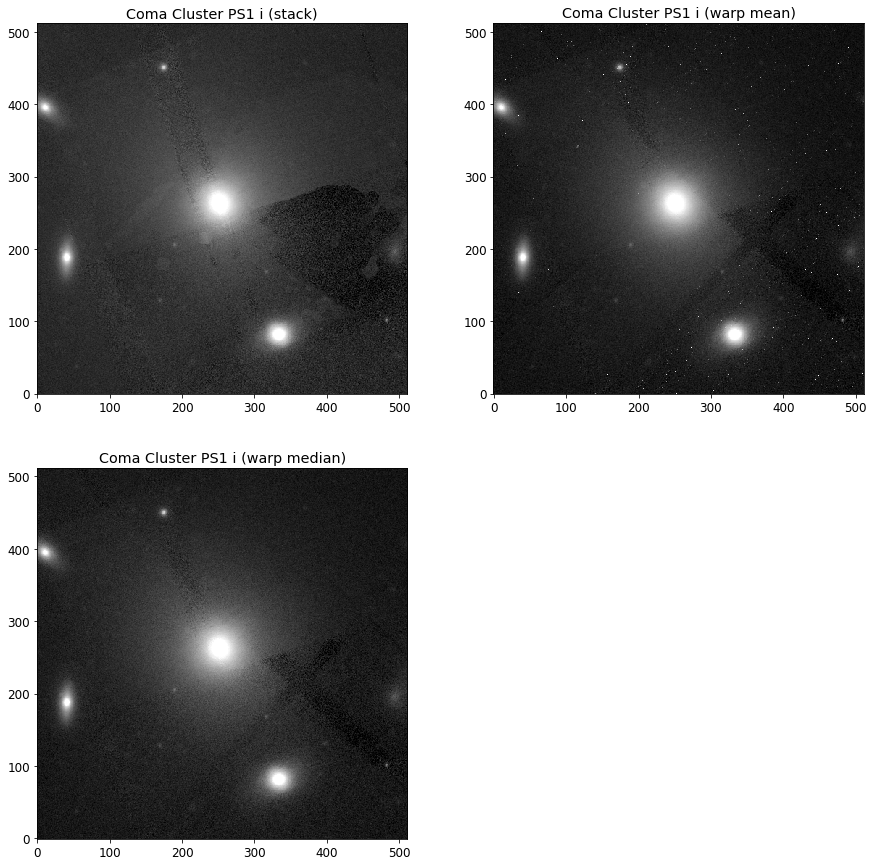

In [26]:
# put the NaN values back into stack
nstack = wstack.copy()
nstack[nstack==0] = numpy.nan

# get mean of warp images ignoring empty pixels
medim = numpy.nanmedian(nstack,axis=0)
print(medim.max(),medim.min())

# set contrast to something reasonable
transform = AsinhStretch() + PercentileInterval(99.5)
bstackim = transform(stackim)
bmeanim1 = transform(meanim1)
bmedim = transform(medim)

pylab.figure(1,(15,15))
pylab.subplot(221)
pylab.imshow(bstackim,cmap="gray",origin="lower")
pylab.title('Coma Cluster PS1 i (stack)')

pylab.subplot(222)
pylab.title('Coma Cluster PS1 i (warp mean)')
pylab.imshow(bmeanim1,cmap="gray",origin="lower")

pylab.subplot(223)
pylab.title('Coma Cluster PS1 i (warp median)')
pylab.imshow(bmedim,cmap="gray",origin="lower")

### Remove median sky offsets and compute new stack

median sky offsets [ 3.8315239   3.8839314  -5.69340467 -5.35438156  0.14150596  0.2744236
 -0.05756044 -3.44689178 -3.80956078  1.3324008   1.19439936  0.96309114]
2918.953953027725 -30.584796905517578


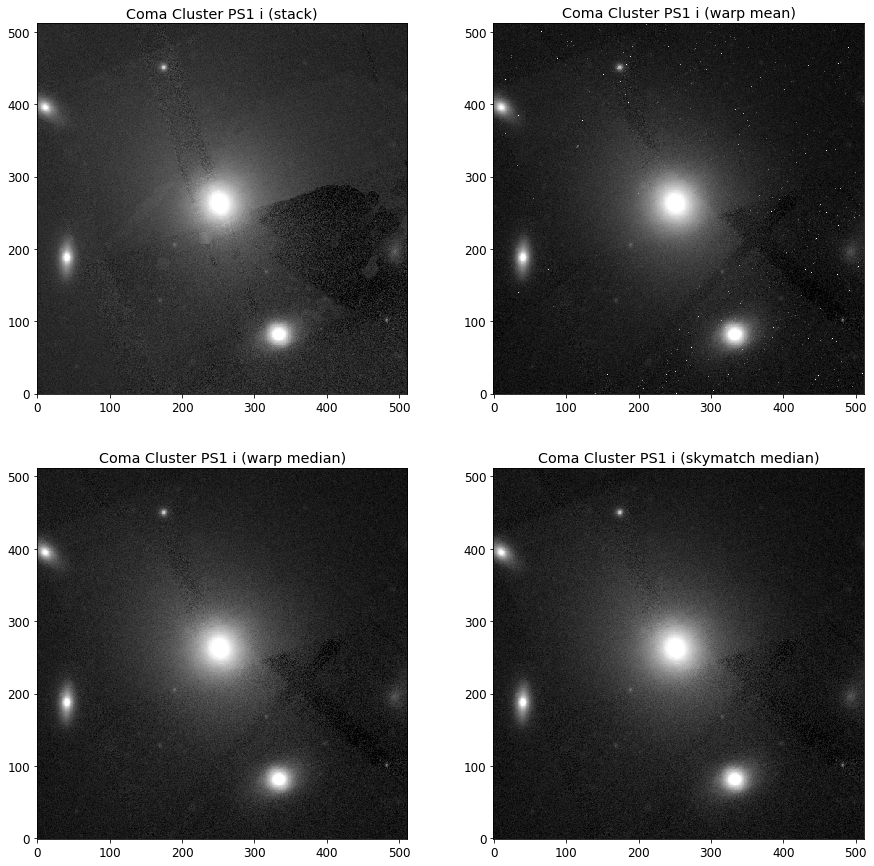

In [28]:
nim = nstack.shape[0]
medskyoffset = numpy.zeros(nim,dtype=float)
for i in range(nim):
    medskyoffset[i] = numpy.nanmedian(nstack[i]-medim)
print('median sky offsets', medskyoffset)

# get mean of warp images ignoring empty pixels
medim2 = numpy.nanmedian(nstack - medskyoffset[:,None,None],axis=0)
print(medim2.max(),medim2.min())

# set contrast to something reasonable
transform = AsinhStretch() + PercentileInterval(99.5)
bstackim = transform(stackim)
bmeanim1 = transform(meanim1)
bmedim = transform(medim)
bmedim2 = transform(medim2)

pylab.figure(1,(15,15))
pylab.subplot(221)
pylab.imshow(bstackim,cmap="gray",origin="lower")
pylab.title('Coma Cluster PS1 i (stack)')

pylab.subplot(222)
pylab.title('Coma Cluster PS1 i (warp mean)')
pylab.imshow(bmeanim1,cmap="gray",origin="lower")

pylab.subplot(223)
pylab.title('Coma Cluster PS1 i (warp median)')
pylab.imshow(bmedim,cmap="gray",origin="lower")

pylab.subplot(224)
pylab.title('Coma Cluster PS1 i (skymatch median)')
pylab.imshow(bmedim2,cmap="gray",origin="lower")

### Do it again using the Crab Nebula

Just use the final median with skymatch algorithm.  The i-band Crab stacked image is pretty poor, so see if we can improve that.

In [63]:
# Crab Nebula position
ra = 83.633210
dec = 22.014460
size = 1280

# get URLs for warp images
warpurls = geturl(ra, dec, size=size, filters="i", format="fits", imagetype="warp")
for i, url in enumerate(warpurls):
    fh = fits.open(url)
    if len(fh)>1:
        fim = fh[1].data
    else:
        fim = fh[0].data
    # note that we don't replace NaN values with zero
    # assume all images will be the same size
    if i == 0:
        wstack = numpy.empty((len(warpurls),fim.shape[0],fim.shape[1]),dtype=fim.dtype)
    wstack[i,:,:] = fim
    fh.close()
    print("Read warp image {} of {}".format(i+1, len(warpurls)))

# eliminate warp images that are completely blank
nnonblank = (wstack!=0).reshape(wstack.shape[0],-1).sum(axis=1)
w = numpy.where(nnonblank != 0)[0]
if len(w) != wstack.shape[0]:
    print("{} of {} warps are blank".format(wstack.shape[0]-len(w),wstack.shape[0]))
    wstack = wstack[w]

# get the PS1 stack image
stackurl = geturl(ra, dec, size=size, filters="i", format="fits", imagetype="stack")
fh = fits.open(stackurl[0])
if len(fh) > 1:
    stackim = fh[1].data
else:
    stackim = fh[0].data
stackim[numpy.isnan(stackim)] = 0.0
fh.close()
print("Read stack image")

Read warp image 1 of 18
Read warp image 2 of 18
Read warp image 3 of 18
Read warp image 4 of 18
Read warp image 5 of 18
Read warp image 6 of 18
Read warp image 7 of 18
Read warp image 8 of 18
Read warp image 9 of 18
Read warp image 10 of 18
Read warp image 11 of 18
Read warp image 12 of 18
Read warp image 13 of 18
Read warp image 14 of 18
Read warp image 15 of 18
Read warp image 16 of 18
Read warp image 17 of 18
Read warp image 18 of 18
Read stack image


### Compute median stack with sky matching

/Users/rlw/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/rlw/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


nan nan
median sky offsets [-15.27891541          nan   6.02832603          nan          nan
 -13.65947342   0.           2.56167412  -9.07134533  -6.24896526
   7.17219019   1.55856323   0.          12.13457775   0.
   0.           0.                  nan]
nan nan


/Users/rlw/anaconda3/lib/python3.6/site-packages/astropy/visualization/stretch.py:333: RuntimeWarning: invalid value encountered in arcsinh
  np.arcsinh(values, out=values)


Text(0.5, 1.0, 'Coma Cluster PS1 i (skymatch median)')

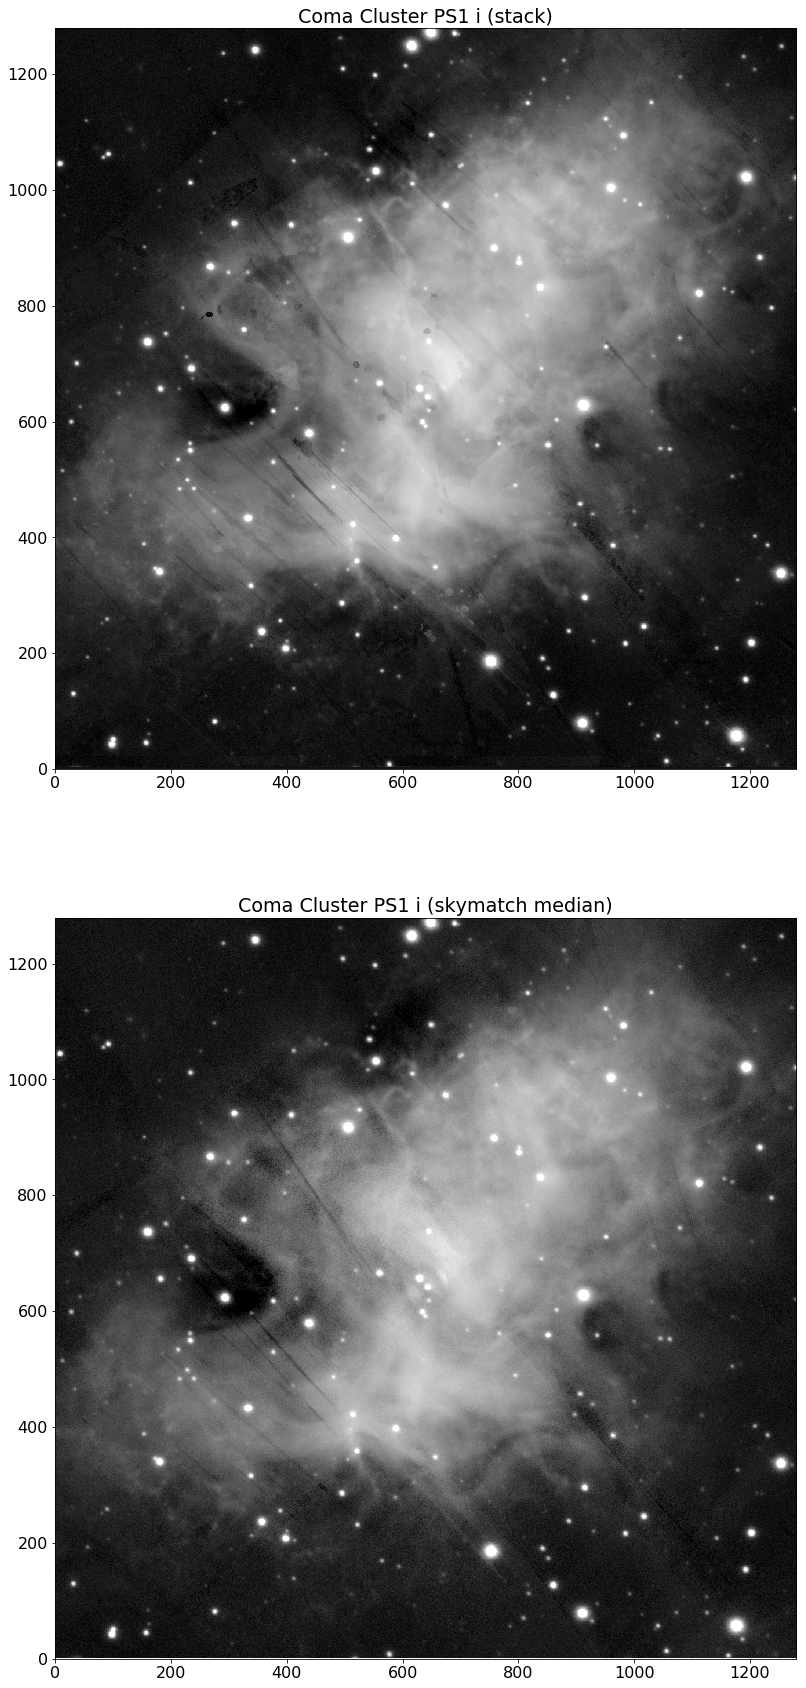

In [64]:
# get mean of warp images ignoring empty pixels
medim = numpy.nanmedian(wstack,axis=0)
print(medim.max(),medim.min())

nim = wstack.shape[0]
medskyoffset = numpy.zeros(nim,dtype=float)
for i in range(nim):
    medskyoffset[i] = numpy.nanmedian(wstack[i]-medim)
print('median sky offsets', medskyoffset)

# get mean of warp images ignoring empty pixels
medim2 = numpy.nanmedian(wstack - medskyoffset[:,None,None],axis=0)
print(medim2.max(),medim2.min())

# set contrast to something reasonable
transform = AsinhStretch() + PercentileInterval(99.5)
bstackim = transform(stackim)
bmedim = transform(medim)
bmedim2 = transform(medim2)

pylab.rcParams.update({'font.size':16})
pylab.figure(1,(15,30))
pylab.subplot(211)
pylab.imshow(bstackim,cmap="gray",origin="lower")
pylab.title('Coma Cluster PS1 i (stack)')

pylab.subplot(212)
pylab.imshow(bmedim2,cmap="gray",origin="lower")
pylab.title('Coma Cluster PS1 i (skymatch median)')

### Create PNG versions of images

Ratio of stackim to medim2= nan


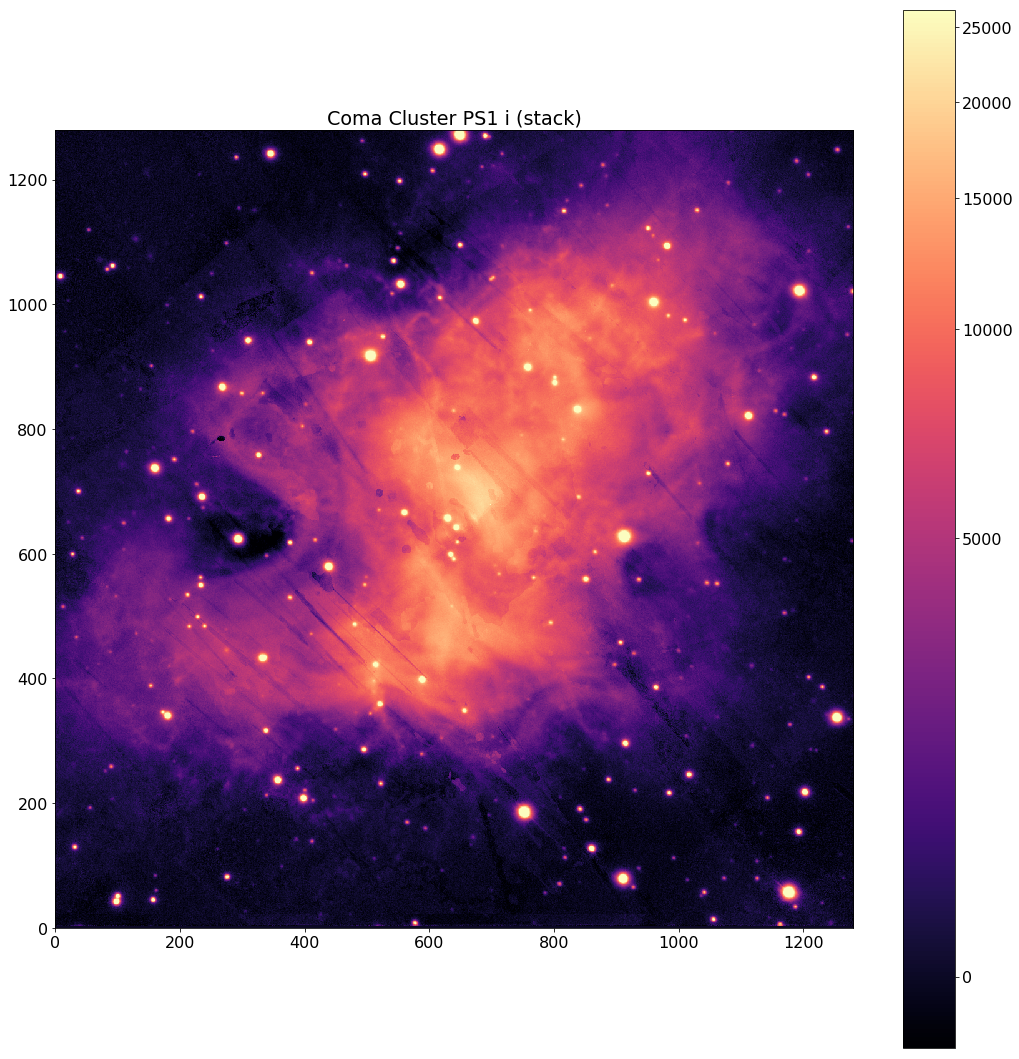

In [67]:
from astropy.visualization import PercentileInterval, AsinhStretch, ImageNormalize

print('Ratio of stackim to medim2=',numpy.median(stackim/medim2))

norm = ImageNormalize(stackim, interval=PercentileInterval(99.5), stretch=AsinhStretch())

pylab.rcParams.update({'font.size':16})
pylab.figure(1,(15,15))
img = pylab.imshow(stackim,cmap="magma",origin="lower",norm=norm)
pylab.title('Coma Cluster PS1 i (stack)')
pylab.colorbar(img)
pylab.tight_layout()
pylab.savefig('crab_i_stack.png')

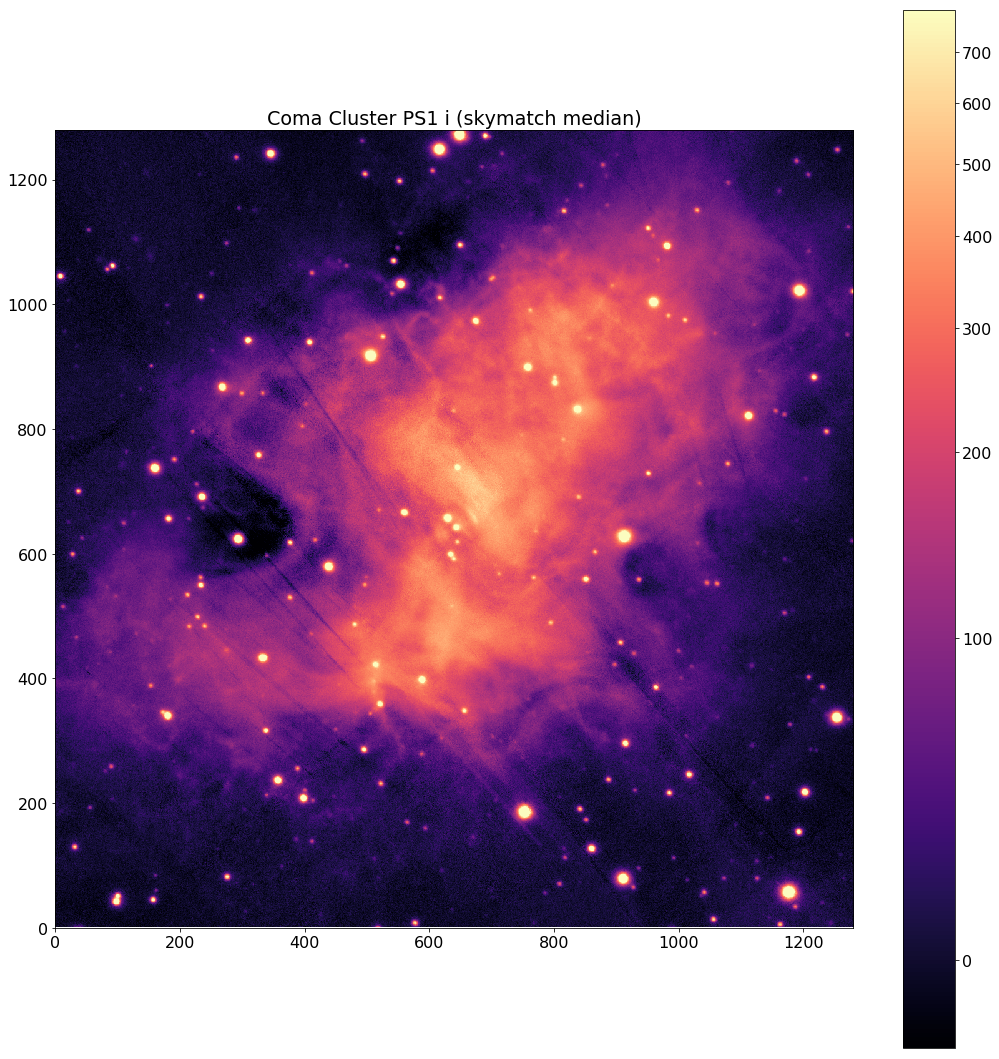

In [68]:
norm = ImageNormalize(medim2, interval=PercentileInterval(99.5), stretch=AsinhStretch())

pylab.figure(1,(15,15))
img = pylab.imshow(medim2,cmap="magma",origin="lower",norm=norm)
pylab.title('Coma Cluster PS1 i (skymatch median)')
pylab.colorbar(img)
pylab.tight_layout()
pylab.savefig('crab_i_medskymatch.png')